## Short-term prediction using LSTM and IBTrACS

v03: Multi-LSTMs = using 1 LSTM per predicted parameter. MLP and LinearRegression models implemented and tested with PyTorch.

Outcome: Linear Regression seems to work better than a MLP to predict next IBTrACS state. It also performs better than MLP. This is not due to our PyTorch implementation of models as a Pytorch-Linear-Regression model gives the same result like scikit-learn module, given a minimum of epochs iterations (~50).

Also, predicting unique state parameter (= [Vmax] alone) instead of a multivariate state (= [lon, lat, Vmax, R34, Rmax]) doesn't change anything to the model performance.

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
# import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable              # Convert arrays to tensors
from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
import pytorch_lightning as pl

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime

# Custom
import dataUtils    as du
import pytorchUtils as pu

# Statistics
from sklearn import linear_model, neighbors

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print('{} GPU(s) available'.format(torch.cuda.device_count()))

Using cuda device
1 GPU(s) available


In [3]:
### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw'] 
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'nature']

### PARAMS
PARAMS = {'seq_len':     4, # length of the input time series used to predict y(t)
          'n_features':  len(params_of_interest),     # nb of output features
          
          # Model parameters
          'input_size':  5,     # nb of input features
          'hidden_size': 20,    # nb of features in hidden state
          'num_layers':  2,     # nb of stacked lstm layers
          'dropout':     0,     # dropout probability
    
          'batch_size':  8,     
          'n_epochs':    30,     # nb of epochs
          'learn_rate':  0.001, # learning rate
          
          'save_figs':       False,
          'feature_scaling': True,
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
    'lstm_path':    '/home/arthur/results/TCsLifeMonitFromObs/lstm_dynamic_pred_ibtracs/lstmv03.pth', 
}

In [4]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])
ds_ibt     = ds_ibt_raw[params_of_interest + additional_info]
# ds_ibt_raw

In [5]:
### FILTERS
# By year
start_date = np.datetime64('2000-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# By latitude
ds_ibt     = ds_ibt.where(np.abs(ds_ibt['lat']) <= 30)
# By removing empty Rmax time series
ds_ibt     = ds_ibt.where(ds_ibt['usa_rmw'].notnull().sum(axis=1) > 5)
# By removing empty R34 time series
ds_ibt     = ds_ibt.where(ds_ibt['usa_r34'].notnull().sum(axis=1) > 5) 

# ==> Drop NaNs
ds_ibt     = ds_ibt.dropna(dim='storm', how='all') # Much quicker to drop NaNs only at the end

# Convert to m/s and km units
ds_ibt['usa_wind'] *= 0.5144
ds_ibt['usa_r34']  *= 1.852
ds_ibt['usa_rmw']  *= 1.852

In [6]:
# LR_variables = ['usa_lon', 'usa_lat', 'usa_r34']
# ds_ibt_LR    = ds_ibt[LR_variables]
# ds_ibt_LR

In [7]:
### CREATE DATASET (Train and test)
# FIRST WE AVERAGE OVER EVERY QUADRANT
# Pre-processing
param_of_interest = ['usa_wind']

MU    = {}
SIG   = {}
SCALE = {'usa_wind': 3,
         'usa_rmw':  3, 
         'usa_r34':  2,
         'usa_lon':  0.5,
         'usa_lat':  1,
}
if PARAMS['feature_scaling']:
    for param in params_of_interest:
        MU[param]     = float(ds_ibt[param].mean(skipna=True))
        SIG[param]    = float(ds_ibt[param].std(skipna=True))
        ds_ibt[param] = SCALE[param] * ((ds_ibt[param] - MU[param]) / SIG[param])

# Separate train and test set
sep1 = int(0.6 * len(ds_ibt['storm'])) # 60% train, 20% valid, 20% test
sep2 = int(0.8 * len(ds_ibt['storm']))
ds_train, ds_valid, ds_test = ds_ibt.isel(storm=slice(None, sep1)), ds_ibt.isel(storm=slice(sep1, sep2)),  ds_ibt.isel(storm=slice(sep2, None))
print('Train set: %i storms;  '%len(ds_train['storm']), 'Valid set: %i storms'%len(ds_valid['storm']), 'Test set: %i storms'%len(ds_test['storm']))

# Create Dataset
X_train, y_train = du.create_dataset(ds_train, params_of_interest, PARAMS)
X_valid, y_valid = du.create_dataset(ds_valid, params_of_interest, PARAMS)
X_test, y_test   = du.create_dataset(ds_test,  params_of_interest, PARAMS)

# Select only one parameter as target
i                = params_of_interest.index(param_of_interest[0])
y_train          = np.expand_dims(np.array(y_train)[:, i], axis=1)
y_valid          = np.expand_dims(np.array(y_valid)[:, i], axis=1)
y_test           = np.expand_dims(np.array(y_test)[:, i], axis=1)


print('Shape of predictors matrix X_train: ', np.asarray(X_train).shape)
print('Shape of targets matrix y_train: ', np.asarray(y_train).shape)

Train set: 150 storms;   Valid set: 50 storms Test set: 50 storms


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 28.23it/s]

Shape of predictors matrix X_train:  (4141, 20)
Shape of targets matrix y_train:  (4141, 1)


In [8]:
# Open Datasets
# Train, valid, and test sets are moved to GPU if available
train_dataset = pu.ShortTimeseriesDataset(X_train, 
                                          y_train,
                                          PARAMS['n_features'],
                                          PARAMS['seq_len'],
                                          device
                                         )
valid_dataset = pu.ShortTimeseriesDataset(X_valid, 
                                          y_valid,
                                          PARAMS['n_features'],
                                          PARAMS['seq_len'],
                                          device
                                         )
test_dataset  = pu.ShortTimeseriesDataset(X_test, 
                                          y_test,
                                          PARAMS['n_features'],
                                          PARAMS['seq_len'],
                                          device
                                         )

# DataLoader
# torch.manual_seed(99)
train_loader = DataLoader(train_dataset, batch_size=PARAMS['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=PARAMS['batch_size'], shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=PARAMS['batch_size'], shuffle=False)

X, y = next(iter(train_loader)) # Check
print("Features shape (batch_size, seq_len, n_features):", X.shape)
print("Target shape (batch_size, n_features):", y.shape)

Features shape (batch_size, seq_len, n_features): torch.Size([8, 4, 5])
Target shape (batch_size, n_features): torch.Size([8, 1])


In [9]:
# Declare model
# Normally, LSTM1 handles batch_size
# model = pu.LSTM1(num_classes=1, 
#                  input_size=PARAMS['input_size'],
#                  hidden_size=PARAMS['hidden_size'],
#                  num_layers=PARAMS['num_layers'],
#                  seq_len=PARAMS['seq_len'],
#                  dropout=PARAMS['dropout'],
# )

model = pu.MLP(input_size=5, seq_len=4, output_size=1)
# model = pu.LinearRegression(input_size=5, seq_len=4, output_size=1)

print(model)
print('Trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))
# Move to GPU if available
model.to(device)

# Loss function, optimizer
loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer     = torch.optim.Adam(model.parameters(), lr=PARAMS['learn_rate']) 

MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)
Trainable parameters: 641


Untrained valid loss
--------
11.184352001384356



  3%|█▍                                          | 1/30 [00:00<00:23,  1.25it/s]

Epoch 0 / 30
---------
Train loss: 1.1763292382287875
Valid loss: 0.1759990741349834



 27%|███████████▋                                | 8/30 [00:06<00:18,  1.18it/s]

Epoch 7 / 30
---------
Train loss: 0.13906241789942025
Valid loss: 0.159599118938489



 50%|█████████████████████▌                     | 15/30 [00:12<00:12,  1.16it/s]

Epoch 14 / 30
---------
Train loss: 0.1292043568667125
Valid loss: 0.09253575972623515



 73%|███████████████████████████████▌           | 22/30 [00:18<00:06,  1.23it/s]

Epoch 21 / 30
---------
Train loss: 0.12177123217286118
Valid loss: 0.08765978002160484



 97%|█████████████████████████████████████████▌ | 29/30 [00:24<00:00,  1.19it/s]

Epoch 28 / 30
---------
Train loss: 0.11971313871702172
Valid loss: 0.11166024251665198



100%|███████████████████████████████████████████| 30/30 [00:25<00:00,  1.20it/s]


<All keys matched successfully>

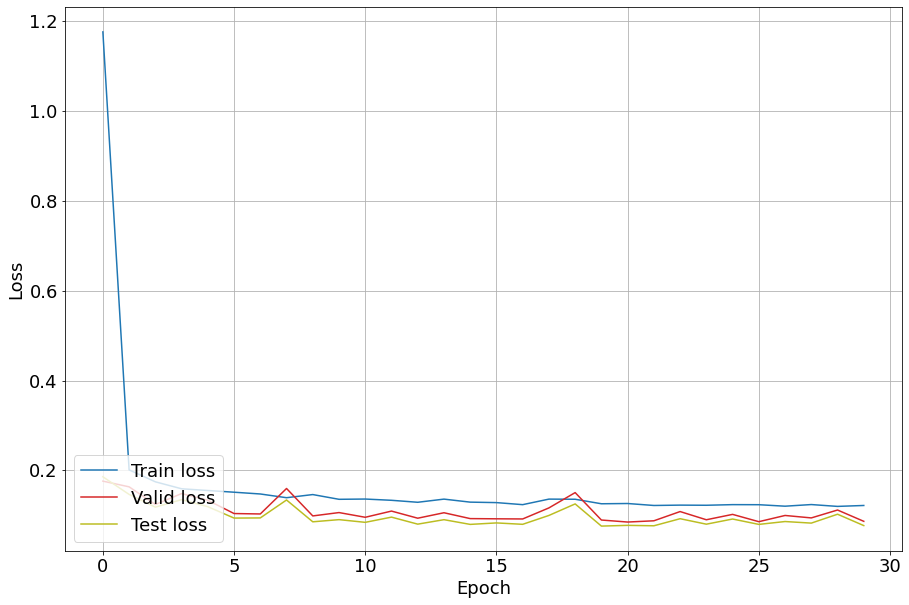

In [10]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss  = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    # print(f"Train loss: {avg_loss}")
    return avg_loss

def valid_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss  = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    # print(f"Valid loss: {avg_loss}")
    return avg_loss
    
def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss  = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    # print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    '''
    CAVEAT: Model is put onto CPU in this function.
    '''
    output = torch.tensor([])
    
    model.cpu()
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

print("Untrained valid loss\n--------")
best_vl = valid_model(valid_loader, model, loss_function)
print(best_vl)
print()

train_loss = []
valid_loss = []
test_loss  = []
for ix_epoch in tqdm(range(PARAMS['n_epochs'])):
    tl = train_model(train_loader, model, loss_function, optimizer=optimizer)
    vl = valid_model(valid_loader, model, loss_function)
    train_loss.append(tl)
    valid_loss.append(vl)
    test_loss.append(test_model(test_loader, model, loss_function))
    if ix_epoch % (PARAMS['n_epochs'] // 4) == 0:
        print(f"Epoch {ix_epoch} / {PARAMS['n_epochs']}\n---------")
        print(f"Train loss: {tl}\nValid loss: {vl}\n")
    # Save model
    if vl < best_vl:
        torch.save(model.state_dict(), PATHS['lstm_path'])

# Plot
plt.plot(train_loss, label='Train loss', color='tab:blue')
plt.plot(valid_loss, label='Valid loss', color='tab:red')
plt.plot(test_loss,  label='Test loss',  color='tab:olive')
plt.xlabel('Epoch');plt.ylabel('Loss')
plt.legend(loc='lower left');plt.grid()

# Load best model
model.load_state_dict(torch.load(PATHS['lstm_path']))

In [11]:
### METRICS
# Linear regression
lrg = linear_model.LinearRegression()
lrg.fit(X_train, y_train)
print('==> LINEAR \nR2: ', lrg.score(X_test, y_test))
print('RMSE {}: '.format(param_of_interest[0]), round(du.rmse(du.inverse_scale_normalize(lrg.predict(X_test), MU, SIG, SCALE, param_of_interest[0]), du.inverse_scale_normalize(np.asarray(y_test), MU, SIG, SCALE, param_of_interest[0])), 2))

# LSTM
test_dataset_cpu = pu.ShortTimeseriesDataset(X_test, y_test, PARAMS['n_features'], PARAMS['seq_len'])
test_loader_cpu  = DataLoader(test_dataset_cpu,  batch_size=PARAMS['batch_size'], shuffle=False)
preds            = predict(test_loader_cpu, model).cpu().detach().numpy()
print('\n==> LSTM')
print('RMSE {}: '.format(param_of_interest[0]), round(du.rmse(du.inverse_scale_normalize(preds, MU, SIG, SCALE, param_of_interest[0]), du.inverse_scale_normalize(np.asarray(y_test), MU, SIG, SCALE, param_of_interest[0])), 2))

==> LINEAR 
R2:  0.9921485250757598
RMSE usa_wind:  1.24

==> LSTM
RMSE usa_wind:  1.34
